<a href="https://colab.research.google.com/github/GustavoHFMO/GrupoSerDisciplinas/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Código adaptado de: https://www.alpha-quantum.com/blog/long-short-term-memory-lstm-with-python/long-short-term-memory-lstm-with-python/



In [25]:
# importando as bibliotecas do projeto
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,accuracy_score,f1_score,roc_curve 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.layers import Activation, Dense, Dropout, Embedding, LSTM 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from keras.models import Sequential


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import random
import time

In [26]:
# definindo uma semente para que os resultados sejam replicaveis
random.seed(10)

In [27]:
# importando o conjunto de dados
num_words = 5000
( X_train , y_train ),( X_test , y_test ) = imdb.load_data(num_words = num_words)

In [28]:
# definindo o formato dos dados para serem compativeis com a entrada da rede
sequence_length = 300
batch_size = 128

# ajustando os padrões de entrada no formato de entrada da rede 
X_train_seq = pad_sequences(X_train, maxlen = sequence_length)
X_test_seq = pad_sequences(X_test, maxlen = sequence_length)

In [29]:
# configurando a lib para converter os labels em numeros
encoder = LabelEncoder()
encoder.fit(y_train)

# convertendo os labels em numeros
y_train_transformed = encoder.transform(y_train).reshape(-1,1)
y_test_transformed = encoder.transform(y_test).reshape(-1,1)

In [31]:
# definindo a estrutura da LSTM
model = Sequential()
model.add(Embedding( num_words , 10 , input_length = sequence_length ))
model.add(LSTM( 128 , dropout = 0.25, recurrent_dropout = 0.25))
model.add(Dense(1, activation = 'sigmoid' ))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 10)           50000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               71168     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 121,297
Trainable params: 121,297
Non-trainable params: 0
_________________________________________________________________


In [32]:
# definindo o algoritmo de treinamento, a função de custo e a metrica de avaliação do conjunto de validação
model.compile( optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'] )

In [33]:
# definindo os criterios de interrupção do treinamento baseado no desempenho no conjunto de validação
early_stopper = EarlyStopping( monitor = 'val_acc' , min_delta = 0.0005, patience = 3 )
reduce_lr = ReduceLROnPlateau( monitor = 'val_loss' , patience = 2 , cooldown = 0)
callbacks = [ reduce_lr , early_stopper]

In [34]:
# treinando o modelo
train_history = model.fit( X_train_seq , y_train_transformed , batch_size = batch_size, epochs = 5,validation_split = 0.1 , verbose = 1 , callbacks = callbacks)

Epoch 1/5
176/176 [==============================] - 206s 1s/step - loss: 0.6792 - accuracy: 0.5886 - val_loss: 0.6287 - val_accuracy: 0.6812
Epoch 2/5
176/176 [==============================] - 202s 1s/step - loss: 0.4444 - accuracy: 0.8056 - val_loss: 0.3685 - val_accuracy: 0.8400
Epoch 3/5
176/176 [==============================] - 203s 1s/step - loss: 0.3409 - accuracy: 0.8540 - val_loss: 0.5199 - val_accuracy: 0.7136
Epoch 4/5
176/176 [==============================] - 203s 1s/step - loss: 0.3150 - accuracy: 0.8692 - val_loss: 0.3862 - val_accuracy: 0.8428
Epoch 5/5
176/176 [==============================] - 203s 1s/step - loss: 0.2368 - accuracy: 0.9054 - val_loss: 0.3006 - val_accuracy: 0.8768


In [35]:
# computando o desempenho da rede para o conjunto de teste
score = model.evaluate( X_test_seq , y_test_transformed , batch_size = batch_size)
 
# printando o resultado da rede 
print( "Accuracy: {:0.4}".format( score[1] ))
print( "Loss:", score[0] )

196/196 [==============================] - 33s 168ms/step - loss: 0.3019 - accuracy: 0.8775
Accuracy: 0.8775
Loss: 0.3019023537635803


In [36]:
# computando a previsão para o conjunto de teste
y_pred = model.predict( X_test_seq )

# calculando a acuracia
print("Accuracy: {:0.3}".format(100 * accuracy_score(y_test_transformed, 1 * (y_pred > 0.5))))
 
# calculando o F1-Score
print("f1 score: {:0.3}".format( 100*f1_score( y_test_transformed , 1 * ( y_pred > 0.5))))
 
# calculando a curva ROC
print("ROC AUC: {:0.3}".format( roc_auc_score( y_test_transformed , y_pred)) )
 
# printando os resultados
print( classification_report( y_test_transformed , 1 * ( y_pred > 0.5 ),digits = 3) )

Accuracy: 87.7
f1 score: 87.8
ROC AUC: 0.948
              precision    recall  f1-score   support

           0      0.879     0.876     0.877     12500
           1      0.876     0.879     0.878     12500

    accuracy                          0.877     25000
   macro avg      0.877     0.877     0.877     25000
weighted avg      0.877     0.877     0.877     25000



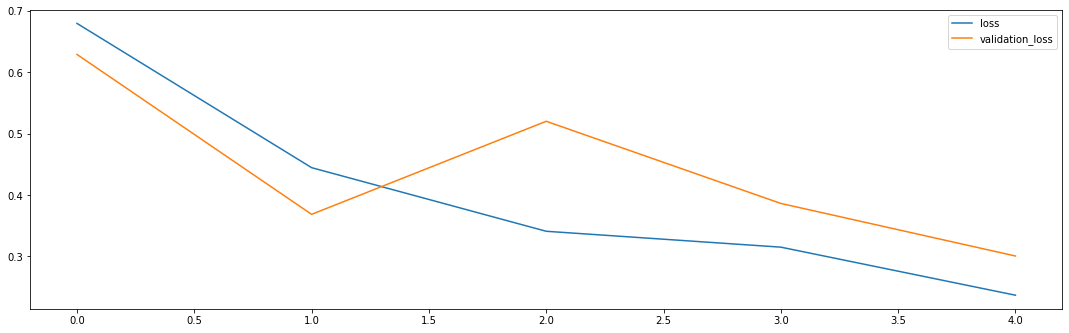

In [37]:
# obtendo o erro da função de custo durante a etapa de treinamento
loss = train_history.history['loss']
validation_loss = train_history.history['val_loss']
  
# gerando o grafico que mostra a evolução da função de custo 
fig = plt.gcf()
fig.set_size_inches(18.5, 5.5)
 
plt.plot(loss)
plt.plot(validation_loss)
 
plt.legend(['loss', 'validation_loss'])
plt.show()